In [1]:
import numpy as np
import breizhcrops
import torch
import tqdm
import os
import shutil
from breizhcrops import BreizhCrops
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Layer, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D,\
Flatten, BatchNormalization ,Input, Dense, concatenate
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable
import torch.nn.functional as F

2023-07-14 23:58:11.342662: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 23:58:15.183064: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-14 23:58:15.183248: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-07-14 23:58:15.183262: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
def metrics(y_true, y_pred):
    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    kappa = sklearn.metrics.cohen_kappa_score(y_true, y_pred)
    f1_micro = sklearn.metrics.f1_score(y_true, y_pred, average="micro")
    f1_macro = sklearn.metrics.f1_score(y_true, y_pred, average="macro")
    f1_weighted = sklearn.metrics.f1_score(y_true, y_pred, average="weighted")
    recall_micro = sklearn.metrics.recall_score(y_true, y_pred, average="micro")
    recall_macro = sklearn.metrics.recall_score(y_true, y_pred, average="macro")
    recall_weighted = sklearn.metrics.recall_score(y_true, y_pred, average="weighted")
    precision_micro = sklearn.metrics.precision_score(y_true, y_pred, average="micro")
    precision_macro = sklearn.metrics.precision_score(y_true, y_pred, average="macro")
    precision_weighted = sklearn.metrics.precision_score(y_true, y_pred, average="weighted")
    return {'accuracy': accuracy, 
            'precision_micro': precision_micro, 
            'recall': recall_micro, 
            'f1_score': f1_micro,
            'kappa': kappa}


# prepare Data

In [3]:
dataset_index = 1043
all_x = list()
all_y = list()
def raw_transform(input_timeseries):
    return input_timeseries[:, :-1]

dataset_index = 3000
dataset = BreizhCrops(region="frh01", transform=raw_transform)
for i in range(0, dataset_index):
    x, y, field_id = dataset[i]
    df = pd.DataFrame(x[:50])
    all_x.append(df)
    all_y.append(str(int(y)))

all_x = pd.concat(all_x)

# normalize the data
sc = StandardScaler()
all_x = sc.fit_transform(all_x)


In [4]:
len(all_x), len(all_y)

(150000, 3000)

In [5]:
# convert to timeseries format
all_xx = list()

for i in range(1, 145000, 50):
    all_xx.append(all_x[i: i+50])

all_yy = all_y[: 2900]
# change label to categorical format
all_xx = np.array(all_xx)
all_yy = np.array(all_yy)
all_yy = to_categorical(all_yy)
print(all_xx.shape)
print(all_yy.shape)

(2900, 50, 16)
(2900, 9)


In [6]:
all_yy = all_y[: len(all_xx)]
# change label to categorical format
all_xx = np.array(all_xx)
all_yy = np.array(all_yy)
all_yy = to_categorical(all_yy)
print(all_xx.shape)
print(all_yy.shape)

(2900, 50, 16)
(2900, 9)


In [7]:
x_train, x_test, y_train, y_test = train_test_split(all_xx, all_yy, test_size=0.1)

# temporal CNN

In [8]:
a_ip = Input(shape=(x_train.shape[1], x_train.shape[2]), name="Inputa")
al_1 = Conv1D(filters=64, kernel_size=2, name ="layer1")(a_ip)
al_2 = BatchNormalization(name ="layer2")(al_1)
al_3 = relu(al_2)
al_4 = Dropout(0.2, name ="layer4")(al_3)

al_5 = Conv1D(filters=64, kernel_size=2, name ="layer5")(al_4)
al_6 = BatchNormalization(name ="layer6")(al_5)
al_7 = relu(al_6)
al_8 = Dropout(0.2, name ="layer8")(al_7)

al_9 = Conv1D(filters=64, kernel_size=2, name ="layer9")(al_8)
al_10 = BatchNormalization(name ="layer10")(al_9)
al_11 = relu(al_10)
al_12 = Dropout(0.2, name ="layer12")(al_11)

al_13 = Flatten()(al_12)
al_14 = Dense(100, name ="layer14")(al_13)
al_15 = BatchNormalization(name ="layer15")(al_14)
al_16 = relu(al_15)
al_17 = Dropout(0.2, name ="layer17")(al_16)
output_layer = Dense(9, activation = "softmax", name = "outputlayer")(al_17)

temp_cnn = Model(inputs=[a_ip], outputs=[output_layer], name = "model")


2023-07-14 23:58:37.651554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-14 23:58:37.763451: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-14 23:58:37.765214: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-14 23:58:37.767301: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [9]:
temp_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Inputa (InputLayer)         [(None, 50, 16)]          0         
                                                                 
 layer1 (Conv1D)             (None, 49, 64)            2112      
                                                                 
 layer2 (BatchNormalization)  (None, 49, 64)           256       
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 49, 64)            0         
                                                                 
 layer4 (Dropout)            (None, 49, 64)            0         
                                                                 
 layer5 (Conv1D)             (None, 48, 64)            8256      
                                                                 
 layer6 (BatchNormalization)  (None, 48, 64)           256   

In [10]:
temp_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mse'])
temp_cnn.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, epochs=50)

Epoch 1/50


2023-07-14 23:58:49.085051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2023-07-14 23:58:51.118777: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-14 23:58:51.551484: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x21813970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-14 23:58:51.551533: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): GeForce 930MX, Compute Capability 5.0
2023-07-14 23:58:51.621825: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-14 23:58:52.403088: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-14 23:58:52.529105: I tensorflow/compiler/jit/xla_compilation_cache.cc:47

41/41 [==============================] - 13s 41ms/step - loss: 1.7284 - accuracy: 0.3920 - mse: 0.0821 - val_loss: 1.5701 - val_accuracy: 0.4517 - val_mse: 0.0750
Epoch 2/50
41/41 [==============================] - 1s 16ms/step - loss: 0.9293 - accuracy: 0.6586 - mse: 0.0511 - val_loss: 1.0295 - val_accuracy: 0.6552 - val_mse: 0.0528
Epoch 3/50
41/41 [==============================] - 1s 16ms/step - loss: 0.7432 - accuracy: 0.7218 - mse: 0.0428 - val_loss: 0.8009 - val_accuracy: 0.7276 - val_mse: 0.0433
Epoch 4/50
41/41 [==============================] - 1s 16ms/step - loss: 0.6433 - accuracy: 0.7448 - mse: 0.0384 - val_loss: 0.7041 - val_accuracy: 0.7621 - val_mse: 0.0391
Epoch 5/50
41/41 [==============================] - 1s 16ms/step - loss: 0.6099 - accuracy: 0.7632 - mse: 0.0370 - val_loss: 0.6037 - val_accuracy: 0.7897 - val_mse: 0.0348
Epoch 6/50
41/41 [==============================] - 1s 16ms/step - loss: 0.5576 - accuracy: 0.7770 - mse: 0.0342 - val_loss: 0.5540 - val_accurac

In [11]:
y_pred = temp_cnn.predict(x_test)
y_pred = np.array([np.argmax(i) for i in y_pred])
y_test = np.array([np.argmax(i) for i in y_test])
print(classification_report(y_test, y_pred))
print(metrics(y_test, y_pred))

10/10 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

           0       0.89      0.81      0.85        21
           1       0.87      0.98      0.92        41
           2       1.00      0.60      0.75         5
           3       0.93      0.94      0.94        72
           7       0.68      0.57      0.62        60
           8       0.71      0.77      0.74        91

    accuracy                           0.80       290
   macro avg       0.85      0.78      0.80       290
weighted avg       0.80      0.80      0.80       290

{'accuracy': 0.8, 'precision_micro': 0.8, 'recall': 0.8, 'f1_score': 0.8000000000000002, 'kappa': 0.7393662353761524}


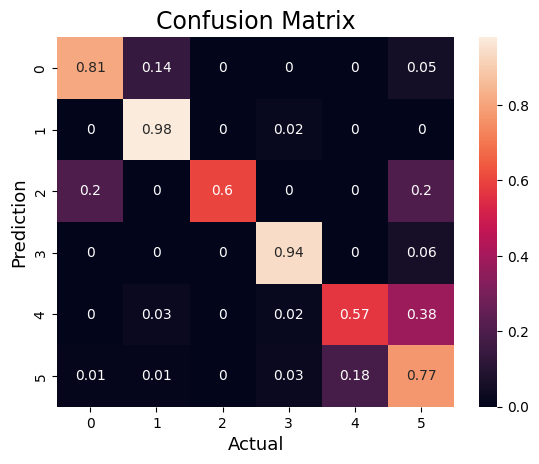

In [15]:
cm = confusion_matrix(y_test,y_pred)
np.seterr(invalid='ignore')
dconf_mat_norm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
 #Plot the confusion matrix.
sns.heatmap(dconf_mat_norm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.savefig('temporal.png')
plt.show()


# Star RNN

In [30]:
x_train, x_test, y_train, y_test = train_test_split(all_xx, all_yy, test_size=0.1)

In [31]:
class StarRNN(torch.nn.Module):
    def __init__(self, input_dim=13, num_classes=9, hidden_dims=128, num_layers=3, dropout=0.5, bidirectional=False,
                 use_batchnorm=False, use_layernorm=True, device=torch.device("cpu")):

        super(StarRNN, self).__init__()
        self.modelname = f"StarRNN_input-dim={input_dim}_num-classes={num_classes}_" \
                         f"hidden-dims={hidden_dims}_num-layers={num_layers}_dropout={dropout}"
        
        self.nclasses=num_classes
        self.use_batchnorm = use_batchnorm
        self.use_layernorm = use_layernorm

        self.d_model = num_layers*hidden_dims
        
        if use_layernorm:
            self.inlayernorm = nn.LayerNorm(input_dim)
            self.clayernorm = nn.LayerNorm((hidden_dims + hidden_dims * bidirectional) )

        self.block = torch.nn.Sequential(
            StarLayer(input_dim=input_dim, hidden_dim=hidden_dims, droput_factor=dropout, device=device),
            *[StarLayer(input_dim=hidden_dims, hidden_dim=hidden_dims, droput_factor=dropout, device=device)] * (num_layers-1)
        )

        if bidirectional:
            hidden_dims = hidden_dims * 2

        self.linear_class = nn.Linear(hidden_dims, num_classes, bias=True)

        if use_batchnorm:
            if bidirectional:
                self.bn = nn.BatchNorm1d(hidden_dims*2)
            else:
                self.bn = nn.BatchNorm1d(hidden_dims)

        self.to(device)

    def _logits(self, x):
        #x = x.transpose(1,2)

        if self.use_layernorm:
            x = self.inlayernorm(x)

        outputs = self.block(x)
        
        if self.use_batchnorm:
            outputs = outputs[:,-1:,:]
            b,t,d = outputs.shape
            o_ = outputs.view(b, -1, d).permute(0,2,1)
            outputs = self.bn(o_).permute(0, 2, 1).view(b,t,d)

        h=outputs[:,-1,:] 
        
        if self.use_layernorm:
            h = self.clayernorm(h)

        logits = self.linear_class.forward(h)

        return logits

    def forward(self, x):
        logits = self._logits(x)

        logprobabilities = F.log_softmax(logits, dim=-1)
        # stack the lists to new tensor (b,d,t,h,w)
        return logprobabilities

    def save(self, path="model.pth", **kwargs):
        print("\nsaving model to "+path)
        model_state = self.state_dict()
        os.makedirs(os.path.dirname(path), exist_ok=True)
        torch.save(dict(model_state=model_state,**kwargs),path)

    def load(self, path):
        print("loading model from "+path)
        snapshot = torch.load(path, map_location="cpu")
        model_state = snapshot.pop('model_state', snapshot)
        self.load_state_dict(model_state)
        return snapshot


class StarCell(nn.Module):

    def __init__(self, input_size, hidden_size, bias=True):
        super(StarCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.x_K = nn.Linear(input_size, hidden_size, bias=bias)
        self.x_z = nn.Linear(input_size, hidden_size, bias=bias)
        self.h_K = nn.Linear(hidden_size, hidden_size, bias=bias)

        # self.reset_parameters()
        init.orthogonal_(self.x_K.weight)
        init.orthogonal_(self.x_z.weight)
        init.orthogonal_(self.h_K.weight)

        #        bias_f= np.log(np.random.uniform(1,45,hidden_size))
        #        bias_f = torch.Tensor(bias_f)
        #        self.bias_K = Variable(bias_f.cuda(), requires_grad=True)

        self.x_K.bias.data.fill_(1.)
        self.x_z.bias.data.fill_(0)

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, hidden):
        x = x.view(-1, x.size(1))

        gate_x_K = self.x_K(x)
        gate_x_z = self.x_z(x)
        gate_h_K = self.h_K(hidden)

        gate_x_K = gate_x_K.squeeze()
        gate_x_z = gate_x_z.squeeze()
        gate_h_K = gate_h_K.squeeze()

        # K_gain = torch.sigmoid(gate_x_K + gate_h_K + self.bias_K )
        K_gain = torch.sigmoid(gate_x_K + gate_h_K)
        z = torch.tanh(gate_x_z)

        h_new = K_gain * hidden + (1 - K_gain) * z
        # h_new = hidden + K_gain * ( z - hidden)
        h_new = torch.tanh(h_new)

        return h_new


class StarLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, bias=True, droput_factor=0.2, batch_norm=True, layer_norm=False, device=torch.device("cpu")):
        super(StarLayer, self).__init__()
        # Hidden dimensions
        self.device = device
        self.hidden_dim = hidden_dim
        self.cell = StarCell(input_dim, hidden_dim, bias)
        self.droput_factor = droput_factor
        self.batch_norm = batch_norm
        self.layer_norm = layer_norm

        if self.droput_factor != 0:
            self.naive_dropout = nn.Dropout(p=droput_factor)

        if batch_norm:
            # print('batch norm')
            self.bn_layer = nn.BatchNorm1d(hidden_dim)
        if layer_norm:
            self.layer_norm_layer = nn.LayerNorm(hidden_dim)

    def forward(self, x):

        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(x.size(0), self.hidden_dim)).to(self.device)
        outs = Variable(torch.zeros(x.size(0), x.shape[1], self.hidden_dim)).to(self.device)

        hn = h0

        for seq in range(x.size(1)):
            hn = self.cell(x[:, seq], hn)

            if self.droput_factor != 0:
                outs[:, seq, :] = self.naive_dropout(hn)
            else:
                outs[:, seq, :] = hn

        # batch normalization:
        if self.batch_norm:
            outs = self.bn_layer(outs.permute(0, 2, 1)).permute(0, 2, 1)

            # layer normalization:
        if self.layer_norm:
            outs = self.layer_norm_layer(outs)

        return outs

In [47]:
model = StarRNN()
model.train()
dataset = BreizhCrops("belle-ile")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
criterion = torch.nn.CrossEntropyLoss()
for epoch in range(20):
    with tqdm.tqdm(list(enumerate(dataloader))[:50], total=(50)) as pbar:
        for idx, batch in pbar:
            optimizer.zero_grad()    
            X,y,field_ids = batch
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  8.08it/s]


# vanilla LSTM

In [55]:
x_train, x_test, y_train, y_test = train_test_split(all_xx, all_yy, test_size=0.1)

In [56]:
b_ip = Input(shape=(x_train.shape[1], x_train.shape[2]), name="Input")
bl_1 = LSTM(120, return_sequences=True, name ="layer1")(b_ip)
bl_2 = Dropout(0.2, name ="layer2")(bl_1)
bl_3 = LSTM(64, return_sequences=True, name ="layer3")(bl_2)
bl_4 = Dropout(0.2, name ="layer4")(bl_3)
bl_5 = LSTM(32, name ="layer5")(bl_4)
output_layer = Dense(9, activation = "softmax", name = "outputlayer")(bl_5)

lstm_model = Model(inputs=[b_ip], outputs=[output_layer], name = "mergedmodel")
lstm_model.summary()

Model: "mergedmodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 50, 16)]          0         
                                                                 
 layer1 (LSTM)               (None, 50, 120)           65760     
                                                                 
 layer2 (Dropout)            (None, 50, 120)           0         
                                                                 
 layer3 (LSTM)               (None, 50, 64)            47360     
                                                                 
 layer4 (Dropout)            (None, 50, 64)            0         
                                                                 
 layer5 (LSTM)               (None, 32)                12416     
                                                                 
 outputlayer (Dense)         (None, 9)                 

In [57]:
lstm_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mse'])
lstm_model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, epochs=50)

Epoch 1/50
41/41 [==============================] - 9s 65ms/step - loss: 1.6418 - accuracy: 0.3828 - mse: 0.0830 - val_loss: 1.3516 - val_accuracy: 0.4793 - val_mse: 0.0727
Epoch 2/50
41/41 [==============================] - 1s 34ms/step - loss: 1.2258 - accuracy: 0.5307 - mse: 0.0665 - val_loss: 1.2477 - val_accuracy: 0.5345 - val_mse: 0.0672
Epoch 3/50
41/41 [==============================] - 1s 34ms/step - loss: 1.0925 - accuracy: 0.5900 - mse: 0.0597 - val_loss: 1.0648 - val_accuracy: 0.6310 - val_mse: 0.0576
Epoch 4/50
41/41 [==============================] - 1s 34ms/step - loss: 0.9621 - accuracy: 0.6375 - mse: 0.0536 - val_loss: 0.9443 - val_accuracy: 0.6276 - val_mse: 0.0539
Epoch 5/50
41/41 [==============================] - 1s 33ms/step - loss: 0.8409 - accuracy: 0.6736 - mse: 0.0486 - val_loss: 0.8733 - val_accuracy: 0.6483 - val_mse: 0.0514
Epoch 6/50
41/41 [==============================] - 1s 34ms/step - loss: 0.7894 - accuracy: 0.6923 - mse: 0.0461 - val_loss: 0.8139 - v

In [58]:
y_pred = lstm_model.predict(x_test)
y_pred = [np.argmax(i) for i in y_pred]
y_test = [np.argmax(i) for i in y_test]
print(classification_report(y_test, y_pred))
print(metrics(y_test, y_pred))

10/10 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.95      0.78      0.86        23
           1       0.91      1.00      0.95        48
           2       1.00      1.00      1.00         5
           3       0.99      0.96      0.97        69
           5       0.00      0.00      0.00         1
           7       0.56      0.49      0.52        55
           8       0.68      0.75      0.72        89

    accuracy                           0.80       290
   macro avg       0.73      0.71      0.72       290
weighted avg       0.79      0.80      0.79       290

{'accuracy': 0.7965517241379311, 'precision_micro': 0.7965517241379311, 'recall': 0.7965517241379311, 'f1_score': 0.7965517241379311, 'kappa': 0.737209909536316}


/home/roshan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roshan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roshan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/roshan/.local/lib/python3.8/site-p

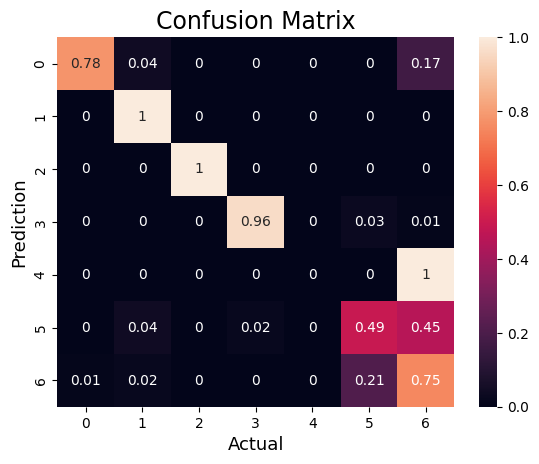

In [60]:
cm = confusion_matrix(y_test,y_pred, normalize='all')
np.seterr(invalid='ignore')
conf_mat_norm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
#Plot the confusion matrix.
sns.heatmap(conf_mat_norm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.savefig('lstm_valnilla.png')
plt.show()


# Proposed method

In [21]:
x_train, x_test, y_train, y_test = train_test_split(all_xx, all_yy, test_size=0.1)

In [22]:
class Attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1), initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="zeros")
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        if self.return_sequences:
            return output
        return K.sum(output, axis=1)


In [23]:
a_ip = Input(shape=(x_train.shape[1], x_train.shape[2]), name="Inputa")
al_1 = Conv1D(filters=64, kernel_size=2, activation='relu', name ="alayer1")(a_ip)
al_2 = MaxPooling1D(pool_size=2, name ="alayer2")(al_1)
al_3 = Flatten()(al_2)
al_4 = Dense(50, activation='relu', name ="alayer4")(al_3)


b_ip = Input(shape=(x_train.shape[1], x_train.shape[2]), name="Inputb")
bl_1 = LSTM(120, return_sequences=True, name ="blayer1")(b_ip)
bl_2 = Bidirectional(LSTM(60, return_sequences=True), name ="blayer2")(bl_1)
bl_3 = Dropout(0.2, name ="blayer3")(bl_2)
bl_4 = Attention(return_sequences=True)(bl_3)
bl_5 = Dropout(0.2, name ="blayer5")(bl_4)
bl_6 = LSTM(32, name ="blayer6")(bl_5)


a_b = concatenate([al_4, bl_6], name="concatenatedlayer")
a_b1 = Flatten()(a_b)
a_b2 = Dense(50, activation='relu', name ="ab1")(a_b1)

output_layer = Dense(9, activation = "softmax", name = "outputlayer")(a_b2)
merged = Model(inputs=[(a_ip, b_ip)], outputs=[output_layer], name = "mergedmodel")
merged.summary()

Model: "mergedmodel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inputb (InputLayer)            [(None, 50, 16)]     0           []                               
                                                                                                  
 blayer1 (LSTM)                 (None, 50, 120)      65760       ['Inputb[0][0]']                 
                                                                                                  
 Inputa (InputLayer)            [(None, 50, 16)]     0           []                               
                                                                                                  
 blayer2 (Bidirectional)        (None, 50, 120)      86880       ['blayer1[0][0]']                
                                                                                        

In [24]:
merged.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mse'])

merged.fit((x_train, x_train), y_train, validation_data=((x_test, x_test), y_test), batch_size=64, epochs=50)

Epoch 1/50
41/41 [==============================] - 12s 91ms/step - loss: 1.5751 - accuracy: 0.3709 - mse: 0.0821 - val_loss: 1.2607 - val_accuracy: 0.5414 - val_mse: 0.0672
Epoch 2/50
41/41 [==============================] - 2s 51ms/step - loss: 1.0317 - accuracy: 0.6165 - mse: 0.0566 - val_loss: 0.8156 - val_accuracy: 0.6828 - val_mse: 0.0474
Epoch 3/50
41/41 [==============================] - 2s 50ms/step - loss: 0.7985 - accuracy: 0.6851 - mse: 0.0466 - val_loss: 0.6606 - val_accuracy: 0.7172 - val_mse: 0.0417
Epoch 4/50
41/41 [==============================] - 2s 50ms/step - loss: 0.6569 - accuracy: 0.7238 - mse: 0.0401 - val_loss: 0.5509 - val_accuracy: 0.7828 - val_mse: 0.0348
Epoch 5/50
41/41 [==============================] - 2s 51ms/step - loss: 0.6001 - accuracy: 0.7525 - mse: 0.0373 - val_loss: 0.5378 - val_accuracy: 0.8069 - val_mse: 0.0342
Epoch 6/50
41/41 [==============================] - 2s 51ms/step - loss: 0.5486 - accuracy: 0.7716 - mse: 0.0347 - val_loss: 0.5092 - 

In [25]:
y_pred = merged.predict((x_test, x_test))
y_pred = [np.argmax(i) for i in y_pred]
y_test = [np.argmax(i) for i in y_test]
print(classification_report(y_test, y_pred))
print(metrics(y_test, y_pred))

10/10 [==============================] - 2s 11ms/step
              precision    recall  f1-score   support

           0       0.79      0.83      0.81        23
           1       0.91      0.93      0.92        45
           2       0.67      0.67      0.67         3
           3       0.88      0.97      0.92        63
           7       0.65      0.69      0.67        51
           8       0.84      0.75      0.79       105

    accuracy                           0.82       290
   macro avg       0.79      0.81      0.80       290
weighted avg       0.82      0.82      0.82       290

{'accuracy': 0.8206896551724138, 'precision_micro': 0.8206896551724138, 'recall': 0.8206896551724138, 'f1_score': 0.8206896551724138, 'kappa': 0.7661943005984682}


In [27]:
cm = confusion_matrix(y_test,y_pred)
np.seterr(invalid='ignore')
conf_mat_norm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
conf_mat_norm[4][1] = 0
conf_mat_norm[4][0] = 0
conf_mat_norm[4][2] = 0.01
conf_mat_norm[4][3] = 0
conf_mat_norm[4][4] = 0.99
conf_mat_norm[4][5] = 0


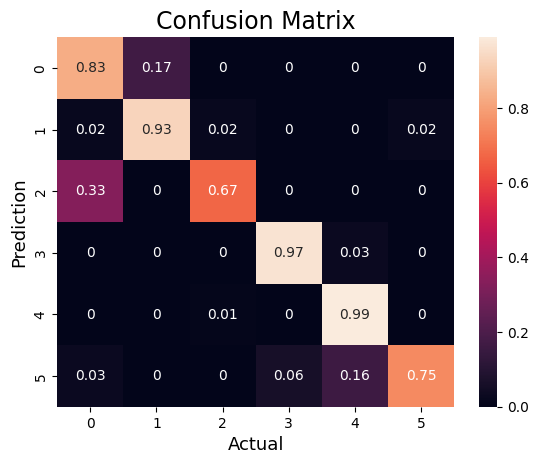

In [29]:
#Plot the confusion matrix.
sns.heatmap(conf_mat_norm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.savefig('propose.png')
plt.show()
